In [2]:
!pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy gensim wordcloud datasets

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
import tiktoken
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
from datasets import load_dataset
from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from nltk import word_tokenize, sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Dataset loading

In [4]:
dataset = load_dataset("yaful/DeepfakeTextDetect")

# Load the train dataset
df = dataset["train"].to_pandas()
df.head()

,text,label,src
0,White girls very rarely date Asian men. Even i...,1,cmv_human
1,I am a 23 year old male Indian American male. ...,1,cmv_human
2,"Take three people, Persons A, B, and C. They l...",1,cmv_human
3,(A) Work part-time in high school; Then go to ...,1,cmv_human
4,When police introduce a new form of speed prev...,1,cmv_human


Text(0.5, 1.0, 'Data Distribution')

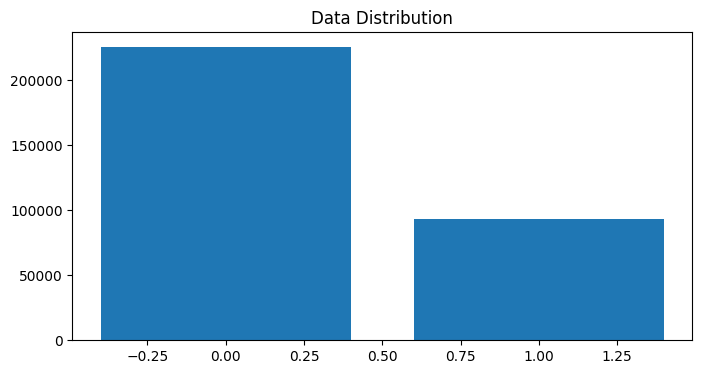

In [5]:
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Data Distribution")

## Preprocessing

In [6]:
def preprocess_text(text):
    # Text to lowercase
    text = text.lower()

    list_text = text.split()

    # Remove stopwords
    list_stopwords = set(nltk.corpus.stopwords.words("english"))
    list_text = [word for word in list_text if word not in list_stopwords]

    # Lemmetize
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    list_text = [lem.lemmatize(word) for word in list_text]

    text = " ".join(list_text)
    return text

In [7]:
# Check if df.pkl exists
try:
    df = pd.read_pickle("df.pkl")
except:
    df["text_preprocess"] = df["text"].apply(lambda x: preprocess_text(x))
    df.to_pickle("df.pkl")

In [8]:
# Save time when retry new model
if "df" not in locals():
    df = pd.read_pickle("df.pkl")

## Training a classifier

In [9]:
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])

    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [10]:
X = df["text_preprocess"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
print(f"Features dimension: {X_train.shape}")

Features dimension: (255256,)


In [11]:
classifier = make_pipeline(TfidfVectorizer(max_features=10000, ngram_range=(1,1), lowercase=False), TfidfTransformer(), LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l2', max_iter = 1000))

In [12]:
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84     45073
           1       0.61      0.76      0.67     18742

    accuracy                           0.79     63815
   macro avg       0.75      0.78      0.76     63815
weighted avg       0.81      0.79      0.79     63815



In [13]:
classifier = make_pipeline(TfidfVectorizer(max_features=10000, ngram_range=(2,2), lowercase=False), TfidfTransformer(), LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l2', max_iter = 1000))

In [14]:
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.71      0.78     45073
           1       0.51      0.73      0.60     18742

    accuracy                           0.71     63815
   macro avg       0.69      0.72      0.69     63815
weighted avg       0.76      0.71      0.73     63815



In [15]:
classifier = make_pipeline(TfidfVectorizer(max_features=10000, ngram_range=(3,3), lowercase=False), TfidfTransformer(), LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l2', max_iter = 1000))

In [11]:
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.47      0.61     45073
           1       0.40      0.85      0.54     18742

    accuracy                           0.58     63815
   macro avg       0.64      0.66      0.58     63815
weighted avg       0.74      0.58      0.59     63815



## Plot confusion matrix

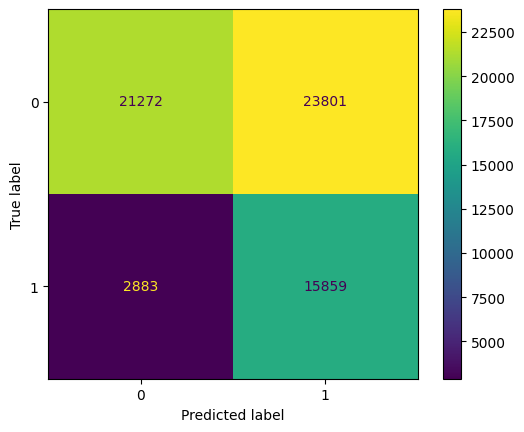

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0,1])
disp.plot()
plt.show()